# ▒  Keras를 활용한 GANs 실습 ▒
    
## Mnist data 사용

## 0. 환경설정

In [55]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

## 1. 데이터 확인

In [56]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [57]:
# 데이터 포맷 확인
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


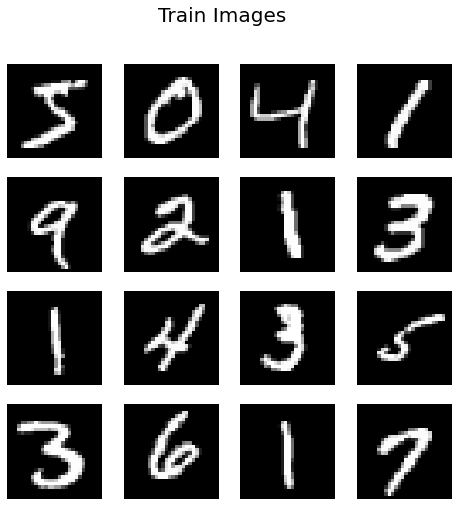

In [58]:
# train 이미지 확인
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)                    # plt.subplot(row, column, index)
    plt.suptitle('Train Images', fontsize=20) # 하나의 큰 제목 설정
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.axis("off")

plt.show()

## 2. 전처리

In [60]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5 

BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 3. keras를 활용한 모델 생성
### 3.1 생성모형 구축

In [61]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
   
    return model

generator = make_generator_model()

### 3.2 구분모형 구축

In [62]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
   
    return model

discriminator = make_discriminator_model()

## 4. 신경망 모델 학습

### 4.1 구분모형 손실함수 정의

In [63]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 4.2. 생성모형 손실함수 정의

In [64]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 4.3 최적화 알고리즘 정의

In [65]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [66]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [67]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        end = time.time()
        print ('Time for epoch {} is {} sec'.format(epoch + 1, end-start))

In [68]:
EPOCHS = 30
train(train_dataset, EPOCHS)

Time for epoch 1 is 35.12040710449219 sec
Time for epoch 2 is 25.38134765625 sec
Time for epoch 3 is 23.504241466522217 sec
Time for epoch 4 is 23.92603087425232 sec
Time for epoch 5 is 23.927464246749878 sec
Time for epoch 6 is 23.741941690444946 sec
Time for epoch 7 is 24.04710602760315 sec
Time for epoch 8 is 23.742584705352783 sec
Time for epoch 9 is 23.755187034606934 sec
Time for epoch 10 is 23.7379891872406 sec
Time for epoch 11 is 24.07156014442444 sec
Time for epoch 12 is 24.076233386993408 sec
Time for epoch 13 is 23.843294143676758 sec
Time for epoch 14 is 23.80284595489502 sec
Time for epoch 15 is 23.658571481704712 sec
Time for epoch 16 is 23.62912392616272 sec
Time for epoch 17 is 23.65412425994873 sec
Time for epoch 18 is 23.60579252243042 sec
Time for epoch 19 is 23.72640037536621 sec
Time for epoch 20 is 23.827637195587158 sec
Time for epoch 21 is 23.733643293380737 sec
Time for epoch 22 is 23.776232957839966 sec
Time for epoch 23 is 23.728172540664673 sec
Time for epo

## 6. 학습한 GAN  모델 평가
### 그림 그려보기

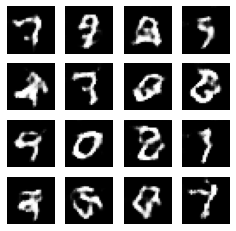

In [70]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
gen_images = generator(seed, training=False)

fig = plt.figure(figsize=(4,4))
for i in range(gen_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(gen_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')